# Overview

 The notebook is modified from "QuickDraw Baseline LSTM Torch "https://www.kaggle.com/kmader/quickdraw-baseline-lstm-torch, by chaning LSTM layer to Bidirectional LSTM layer and add Bach Normalization layer to prevent from Gradient Vanishing/Exploding problem. 
 
 "QuickDraw Baseline LSTM Torch" kernel uses stroke-based LSTM, it means not from original image data, but from processed stroke vector data. And 'preprocesses' uses 1D convolutions and then uses two stacked LSTMs followed by two dense layers to make the classification. The model can be thought to 'read' the drawing stroke by stroke.

### Model Parameters
Here we keep track of the relevant parameters for the data preprocessing, model construction and training

In [226]:
batch_size = 2048
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50
use_gpu = True
LEARNING_RATE = 1e-3
EPOCHS = 50

In [227]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from glob import glob
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional as F
import gc
gc.enable()

In [228]:
base_dir = os.path.join('..', 'input')
test_path = os.path.join(base_dir, 'test_simplified.csv')

In [229]:
device = torch.device("cuda" if use_gpu else "cpu")
torch.manual_seed(42) # try and make the results more reproducible

## Import the Data
Read and process the stroke data

In [230]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

# Reading and Parsing
Since it is too much data (23GB) to read in at once, we just take a portion of it for training, validation and hold-out testing. This should give us an idea about how well the model works, but leaves lots of room for improvement later

In [231]:
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

# Stroke-based Classification
Here we use the stroke information to train a model and see if the strokes give us a better idea of what the shape could be. 

In [244]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(255000, 196, 3)


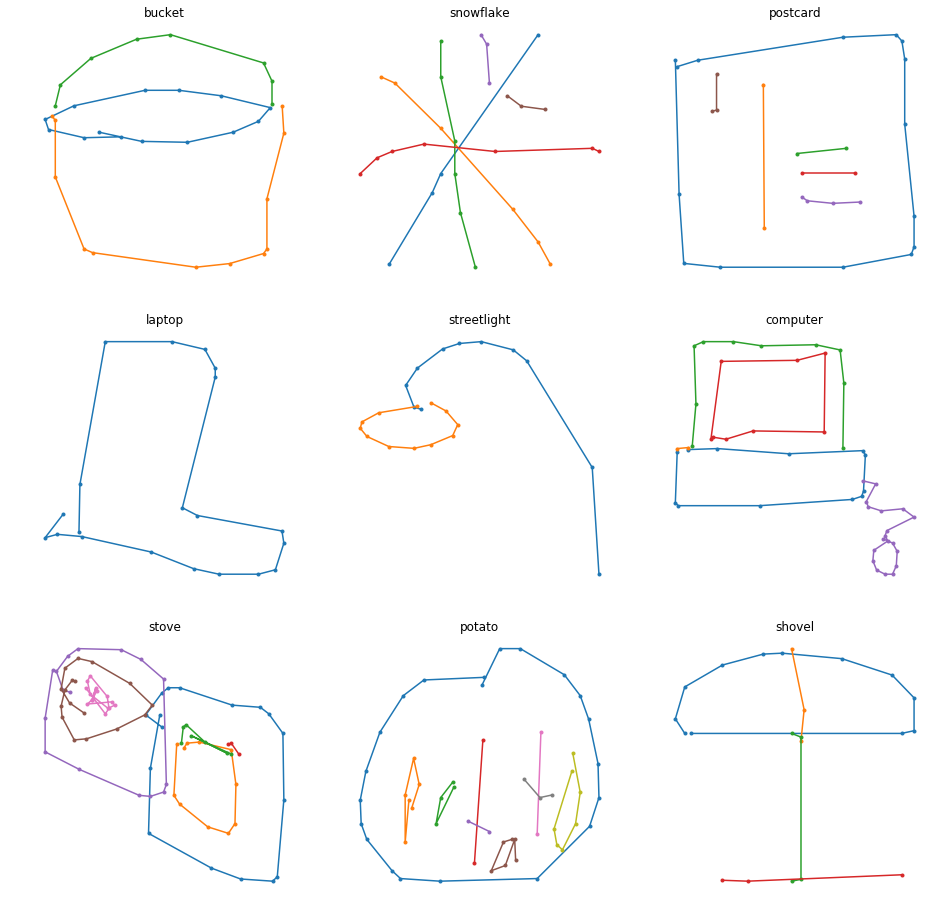

In [245]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

# LSTM to Parse Strokes
The model suggeted from the tutorial is

![Suggested Model](https://www.tensorflow.org/versions/master/images/quickdraw_model.png)

In [246]:
class LSTMNet(nn.Module):
    def __init__(self, in_channels, classes):
        """Define the components of a LSTM Stroke Model"""
        super(LSTMNet, self).__init__()   
        self.bn1 = nn.BatchNorm1d(num_features=48)
        self.relu = nn.ReLU(inplace=True)
        self.conv_1 = nn.Conv1d(in_channels=in_channels, out_channels=48, kernel_size=5)
        self.conv_2 = nn.Conv1d(in_channels=48, out_channels=64, kernel_size=5)
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=96, kernel_size=3)
        
        self.lstm = nn.LSTM(input_size=96, hidden_size=128, 
                            batch_first=False,
                            dropout=0.3, num_layers=2, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.feat_vec = nn.Linear(256, 512)
        self.pred = nn.Linear(512, classes)

    def forward(self,x):
        """Input x is expected to be a 3d tensor (N x seq_length x C)
           N - Number of images in minibatch
           seq_length - Length of the sequen
           C - number of channels"""
        x = self.bn1(self.conv_1(x))
        #x = self.relu(x)
        x = self.dropout(x)
        x = self.relu(self.conv_2(x))
        x = self.dropout(x)
        x = self.relu(self.conv_3(x))
        x = self.dropout(x)
        x = x.permute(2, 0, 1) # prepare for the LSTM
        output, (h_0, c_0) = self.lstm(x)
        #print("output shape : ", output.shape) #[186,2048,256]
        x = self.relu(self.feat_vec(output[-1]))
        return self.pred(x)

In [247]:
model = LSTMNet(classes=len(word_encoder.classes_), in_channels = train_X.shape[2]).to(device)
model

LSTMNet(
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv_1): Conv1d(3, 48, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(48, 64, kernel_size=(5,), stride=(1,))
  (conv_3): Conv1d(64, 96, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(96, 128, num_layers=2, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3)
  (feat_vec): Linear(in_features=256, out_features=512, bias=True)
  (pred): Linear(in_features=512, out_features=340, bias=True)
)

In [248]:
criterion = nn.CrossEntropyLoss() #Use cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Prepare Training Data

In [249]:
train_loader = torch.utils.data.DataLoader(list(zip(train_X.swapaxes(1, 2).astype('float32'), # pytorch and tf/keras have different orders
                                                    np.argmax(train_y, 1)
                                                   )),
                                           shuffle=True, batch_size=batch_size, 
                                           pin_memory=False)
test_loader = torch.utils.data.DataLoader(list(zip(valid_X.swapaxes(1, 2).astype('float32'), 
                                                   np.argmax(valid_y, 1)
                                                  )),
                                           shuffle=True, batch_size=batch_size, 
                                           pin_memory=False)

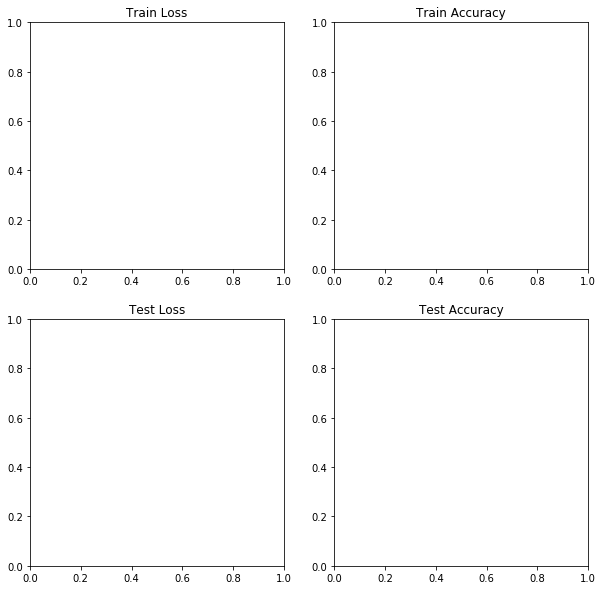

Epoch  0


RuntimeError: CUDA out of memory. Tried to allocate 4.02 GiB (GPU 0; 15.90 GiB total capacity; 9.32 GiB already allocated; 2.96 GiB free; 2.91 GiB cached)

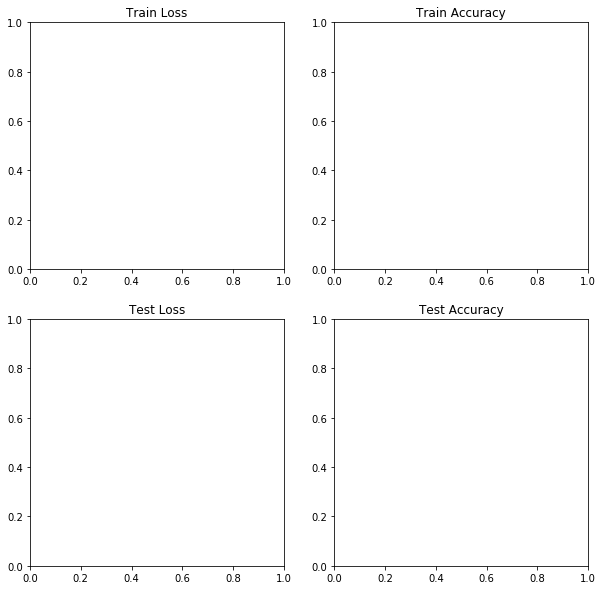

In [250]:
# nice wait bars
from tqdm import tqdm_notebook, tnrange
from collections import defaultdict
from IPython.display import clear_output, display
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

for i in tnrange(EPOCHS, desc='Epochs'):
    clear_output(wait=True)
    display(fig)
    print("Epoch ",i)
    ## Train Phase
    #Model switches to train phase
    model.train() 
    
    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for data, target in tqdm_notebook(train_loader, desc='Training'):    
        if use_gpu: #Using GPU & Cuda
            data, target = data.to(device), target.to(device)

        output = model(data) #FWD prop
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax1.plot(count, c_loss, 'r.')
        loss_val += c_loss

        optimizer.zero_grad() #Zero out any cached gradients
        loss.backward() #Backward pass
        optimizer.step() #Update the weights

        #Compute accuracy
        predicted = output.data.max(1)[1] #get index of max
        total += target.size(0) #total samples in mini batch
        c_acc = (predicted == target).sum().item()
        ax2.plot(count, c_acc/target.size(0), 'r.')
        correct += c_acc
        count +=1
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    ## Test Phase
    
    #Model switches to test phase
    model.eval()

    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for data, target in tqdm_notebook(test_loader, desc='Testing'):
        if use_gpu: #Using GPU & Cuda
            data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        #Compute accuracy
        predicted = output.data.max(1)[1] #get index of max
        total += target.size(0) #total samples in mini batch
        c_acc = (predicted == target).sum().item()
        ax4.plot(count, c_acc/target.size(0), 'b.')
        correct += c_acc
        count += 1

    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Epoch: ",i," test set accuracy: ",test_acc)
    
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth') 
# plt.show()
# fig.savefig('train.png')

In [ ]:
train_results_df = pd.DataFrame(train_results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
train_results_df.plot('epoch', ['train_loss', 'test_loss'], ax=ax1)
ax1.set_title('Loss')
train_results_df.plot('epoch', ['train_acc', 'test_acc'], ax=ax2)
ax2.set_title('Accuracy')
fig.savefig('epochs.png')

In [ ]:
# load the best model
model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
#Model switches to test phase
top_k_count = 5
model.eval()
#Running through all mini batches in the dataset
count, correct, top_k_correct, total, lost_val = test_iter, 0, 0, 0, 0
pred_cat = []
test_cat = []
for data, target in tqdm_notebook(test_loader, desc='Testing'):
    if use_gpu: #Using GPU & Cuda
        data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target) #Cross entropy loss
    c_loss = loss.data.item()
    loss_val += c_loss
    #Compute accuracy
    predicted = output.data.max(1)[1] #get index of max
    # add outputs for better visualization
    test_cat.append(output.data.max(1)[1].cpu().numpy())
    pred_cat.append(target.data.cpu().numpy())
        
    total += target.size(0) #total samples in mini batch
    c_acc = (predicted == target).sum().item()
    top_k_correct += c_acc
    for k in range(1, top_k_count+1):
        top_k_correct += (output.data.argsort(1, descending=True)[:, k] == target).sum().item()
    correct += c_acc
    count += 1

#Accuracy over entire dataset
test_acc, test_iter, test_loss_val, top_k_acc = correct/float(total), count, loss_val/len(test_loader.dataset), top_k_correct/float(total)
test_cat = np.concatenate(test_cat, 0)
pred_cat = np.concatenate(pred_cat, 0)
print('Accuracy: %2.1f%%, Top %d Accuracy %2.1f%%' % (100*test_acc, top_k_count, 100*top_k_acc))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))

# Reading Point by Point

# Submission
We can create a submission using the model

In [ ]:
sub_df = pd.read_csv(test_path)
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)

In [ ]:
sub_vec = np.stack(sub_df['drawing'].values, 0)

In [ ]:
submission_loader = torch.utils.data.DataLoader(list(zip(sub_vec.swapaxes(1, 2).astype('float32'), 
                                                   sub_df.index.values
                                                  )),
                                           shuffle=False, batch_size=batch_size, 
                                           pin_memory=False)

In [ ]:
# make the predictions
model.eval()
pred_out = []
idx_out = []
for data, target in tqdm_notebook(submission_loader, desc='Testing'):
    if use_gpu: #Using GPU & Cuda
        data = data.to(device) 
    output = model(data)
    pred_out += [output.data.cpu().numpy()]
    idx_out += [target.numpy()]
pred_out = np.concatenate(pred_out, 0)
idx_out = np.concatenate(idx_out, 0)

In [ ]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in pred_out]

In [ ]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

In [ ]:
sub_out_df = pd.DataFrame({'key_id': sub_df['key_id'][idx_out].values, 
                          'word': top_3_pred})
sub_out_df[['key_id', 'word']].to_csv('submission.csv', index=False)
sub_out_df.sample(5)